# Image Processing

In this notebook, we examine all raw cropped cell images and prepare them for classification by filtering and augmentation.

### Table of Contents<span class="tocSkip">
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Image-Examination" data-toc-modified-id="1.-Image-Examination-1">1. Image Examination</a></span></li><li><span><a href="#2.-Image-Resizing" data-toc-modified-id="2.-Image-Resizing-2">2. Image Resizing</a></span><ul class="toc-item"><li><span><a href="#2.1.-Image-Size-Distribution" data-toc-modified-id="2.1.-Image-Size-Distribution-2.1">2.1. Image Size Distribution</a></span></li><li><span><a href="#2.2.-Image-Padding" data-toc-modified-id="2.2.-Image-Padding-2.2">2.2. Image Padding</a></span></li></ul></li><li><span><a href="#3.-Image-Filtering" data-toc-modified-id="3.-Image-Filtering-3">3. Image Filtering</a></span><ul class="toc-item"><li><span><a href="#3.1.-Entropy-Ordering" data-toc-modified-id="3.1.-Entropy-Ordering-3.1">3.1. Entropy Ordering</a></span></li><li><span><a href="#3.2.-Entropy-Thresholding" data-toc-modified-id="3.2.-Entropy-Thresholding-3.2">3.2. Entropy Thresholding</a></span><ul class="toc-item"><li><span><a href="#3.2.1-Normal-based-Thresholding" data-toc-modified-id="3.2.1-Normal-based-Thresholding-3.2.1">3.2.1 Normal-based Thresholding</a></span></li></ul></li><li><span><a href="#3.3.-Two-step-Thresholding" data-toc-modified-id="3.3.-Two-step-Thresholding-3.3">3.3. Two-step Thresholding</a></span></li><li><span><a href="#3.4.-Multiple-cell-Detection" data-toc-modified-id="3.4.-Multiple-cell-Detection-3.4">3.4. Multiple-cell Detection</a></span></li></ul></li><li><span><a href="#4.-Image-Augmentation" data-toc-modified-id="4.-Image-Augmentation-4">4. Image Augmentation</a></span><ul class="toc-item"><li><span><a href="#4.1.-Rotation" data-toc-modified-id="4.1.-Rotation-4.1">4.1. Rotation</a></span></li><li><span><a href="#4.2.-Mirroring" data-toc-modified-id="4.2.-Mirroring-4.2">4.2. Mirroring</a></span></li></ul></li><li><span><a href="#5.-Summary" data-toc-modified-id="5.-Summary-5">5. Summary</a></span></li></ul></div>

Before running any cells in this notebook, you want to first unzip `./images/sample_images.zip`, so you can get the sample images. The code below checks if you have already uncompressed the zip file. If not, it unzips it for you.

In [1]:
%%bash

if [ ! -e ./images/sample_images ]
then
    unzip -q ./images/sample_images.zip -d ./images/
    echo "Successfully uncompressed sample_images.zip"
else
    echo "Sample images exist"
fi

Successfully uncompressed sample_images.zip


## 1. Image Examination

It is a good practice to visualize all images together first. It helps us to get a big idea of what image processing methods are needed for the dataset.

We can use [ImageMagic Montage](https://www.imagemagick.org) to easily display all images.

In [2]:
# Remove the `#` below to run the bash command
#!montage ./images/sample_images/original/*/*/*.png ./plots/before_padding.png

![](./plots/before_padding.png)

## 2. Image Resizing

We notice the size variation from all images. It is more convenient to work with images with equal shapes. Therefore, we want to assess the relationship between image size and cell activity classification, then choose image resizing methods accordingly.

### 2.1. Image Size Distribution

In [3]:
import re
import os
import cv2
import math
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
from glob import glob
from os.path import join, exists, basename, normpath, split
from matplotlib import pyplot as plt
from PIL import Image
from shutil import copyfile
from scipy.stats import norm

In [4]:
def sum_hist(input_dir):
    """
    Find the histogram over all grayscale images in the input_dir.
    Instead of listing all images into one matrix, simply sum the intensity.
    
    Args:
        input_dir (string): path of the directory containing all png images
    
    Returns:
        array: A length 256 array corresponding to the pixel intensity frequency
    """
    hist = np.zeros(256)
    count = 0
    for image in glob(join(input_dir, "*.png")):
        # Read the image
        img = cv2.imread(image, 0)
        cur_hist = cv2.calcHist([img],[0], None, [256], [0,256]).flatten()
        hist = hist + cur_hist
        count += 1
     
    # Compute the frequency
    return hist / sum(hist)

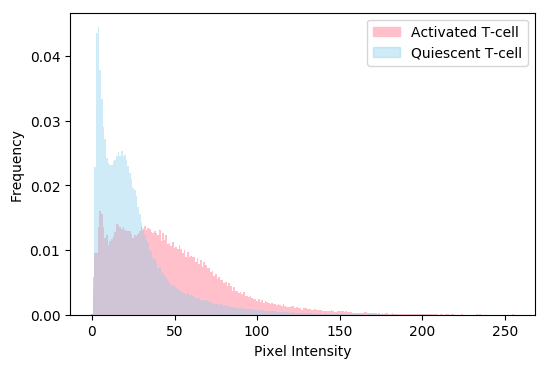

In [5]:
# Plot the pixel intensity frequency 
act_hist = sum_hist("./images/sample_images/original/*/activated")
qui_hist = sum_hist("./images/sample_images/original/*/quiescent")

plt.figure(dpi=100)
plt.bar(range(256), act_hist, width=1, align='center', color="pink")
plt.bar(range(256), qui_hist, width=1, align='center', color=(135/255,
                                                              206/255,
                                                              235/255,
                                                              0.4))
pink_patch = mpatches.Patch(color='pink', label='Activated T-cell')
blue_patch = mpatches.Patch(color=(135/255, 206/255, 235/255, 0.4),
                            label='Quiescent T-cell')
plt.legend(handles=[pink_patch, blue_patch])
plt.ylabel('Frequency')
plt.xlabel('Pixel Intensity')
plt.show(2)

### 2.2. Image Padding

Based on the distribution above, quiescent cell images are more likely to have lower intensities (dimmer). Therefore, we want to preserve the original image size after unifying all image shapes. One way to achieve this is to add paddings to all images. We first find the largest width $w$ and height $h$, then make all images have the same square shape ($\max\left(w, h\right) \times \max\left(w, h\right)$) by adding black borders around them.

It is not necessarily to resize all images to the largest size. For example, if there are some extremely large images (outliers) in your dataset, you might want to discard them before choosing the $\max\left(w, h\right)$.

In [6]:
def get_max_dimension(input_dir, top_num=3):
    """
    Find `top_num` largest dimension (height or width) of all images in the
    input_dir. You can visualize the image source to decide which diemsion
    value to use.
    
    Args:
        input_dir (string): A directory containing png images
        top_num (integer): Number of largest lengths to return
    
    Returns:
        list(tuple): A list of top `top_num` dimension lengths and their
            associated image names
    """
    lengths = []
    for image in glob(join(input_dir, "*.png")):
        img = Image.open(image)
        width, height = img.size
        lengths.append((max([width, height]), image, width, height))

    # Get the top 3 options
    sorted_lengths = sorted(lengths, key=lambda x: x[0], reverse=True)
    return sorted_lengths[:top_num]

In [7]:
def add_padding(image, max_length, padding_color="black", output=None):
    """
    This function adds padding around the image so the new shape
    is (max_length * max_length).
    
    Args:
        image (string): path of the image file
        max_length (int): output square length
        padding_color (string): color of the borders
        output (string): output path of the result image. If it is
            None, then the new image is not saved
    
    Returns:
        array: the new image
    """

    img = Image.open(image)
    width, height = img.size

    # Create a new 8-bit B&W image with black background
    new_image = Image.new('L', (max_length, max_length), color=padding_color)

    # Put the original image in the center
    x_shift = (max_length - width) // 2
    y_shift = (max_length - height) // 2
    new_image.paste(img, (x_shift, y_shift,
                          width + x_shift, height + y_shift))
    
    # Save the image if needed
    if output:
        new_image.save(output)
    
    return np.array(new_image)

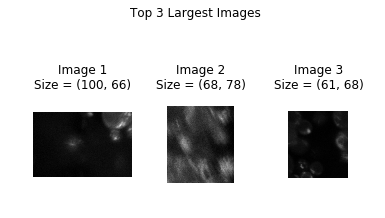

In [8]:
# Display the three largest images
largest_three = get_max_dimension("./images/sample_images/original/*/*")

# Add padding to these three images, so their displays have the same scale
padded_top_three = [
    add_padding(img[1], largest_three[0][0], padding_color="white") for
    img in largest_three
]

fig=plt.figure()

for i in range(3):
    img = padded_top_three[i]
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title("Image {}\nSize = ({}, {})".format(
        i+1, largest_three[i][2], largest_three[i][3]))

fig.suptitle("Top 3 Largest Images")
plt.show()

There is a significant gap between the largest length $100$ and the second largest length $78$, and Image 1 looks like an outlier due to bad cropping. Even though image 2 and image 3 are likely to suffer from bad cropping, we will discard Image 1 and use $78$ as the largest length to resize other images.

In [9]:
# Add padding to all images except Image 1 above
image_1 = largest_three[0][1]
discard_images = set([image_1])
max_length = 78

for image_path in glob("./images/sample_images/original/*/*/*.png"):
    # Ignore image 1
    if image_path in discard_images:
        continue

    # Get the output path
    image_output = image_path.replace("original", "processed/padded")
    
    # Create intermediate directories if they do not exist yet
    intermediate_dirs, _ = os.path.split(image_output)
    if not exists(intermediate_dirs):
        os.makedirs(intermediate_dirs)
    
    # Process the current image
    add_padding(image_path, max_length, padding_color="black",
                output=image_output)

Then, we can visualize all padded images.

In [10]:
# Remove the `#` below to run the bash command
#!montage ./images/sample_images/processed/padded/*/*/*.png -geometry +1+1 ./plots/after_padding.png

![](./plots/after_padding.png)

## 3. Image Filtering

As we have seen above, many images are very dim and there is no cell in the image. We want to design a filter to automatically detect those images, and eventually discard them from our dataset.

### 3.1. Entropy Ordering

Entropy is a statistical measure of the information and variance in images. It can characterize the texture and help us detect less useful cell images.

In [11]:
def compute_entropy(img_name):
    """
    Compute the entropy function (like entropy() in Matlab)
    
    Args:
        image_name(string): path to the image
    
    Returns:
        int: entropy to the image
    """

    img = cv2.imread(img_name, 0)
    
    cur_hist = cv2.calcHist([img],[0], None, [256], [0,256]).flatten()

    # Remove zeroes
    hist_no_zero = np.array([i for i in cur_hist if i != 0])

    # Normalize the hist so it sums to 1
    hist_no_zero = hist_no_zero / np.size(img)

    # Compute the entropy
    log_2 = np.log(hist_no_zero) / np.log(2)
    entropy = -1 * np.dot(hist_no_zero, log_2)
    return entropy


def montage_images(img_names, n_col, image_size=50, margin=2):
    """
    Plot all the images listed in `img_names` in a gird with `n_col` columns.
    Images will be resized to `image_size`*`image_size`.
    This function assumes input images have the same shape.
    
    Args:
        img_names([string]): list of image paths
        n_col(int): number of images in one row
        image_size(int): the length of each image on the montage view
        margin(int): the horizonal and vertical gap between image image
        
    Returns:
        np.array: The montage view of all images listed in `img_names`
    """
    img_list = []
    for i in img_names:
        img_list.append(cv2.resize(cv2.imread(i, 0), (image_size, image_size)))
    stack = np.hstack(img_list)

    # Compute number of rows
    n_row = math.ceil(len(img_names) / n_col)
    image = np.ones((n_row * image_size + (n_row - 1) * margin,
                     n_col * image_size + (n_col - 1) * margin)) * 255

    for i in range(int(stack.shape[1] / image_size)):
        r, c = i // n_col, i % n_col
        image[image_size * r + r * margin : image_size * (r + 1) + r * margin,
              image_size * c + c * margin : image_size * (c + 1) + c * margin
             ] = stack[:, image_size * i : image_size * (i + 1)]
        
    return image

In [12]:
# Compute the entropies on original images
entropy_pairs = [(n, compute_entropy(n)) for n in
                 set(glob("./images/sample_images/original/*/*/*.png")) -
                 discard_images]

# Sort images by increasing entropy
original_images_sorted = [i[0] for i in sorted(entropy_pairs,
                                               key=lambda x: x[1])]

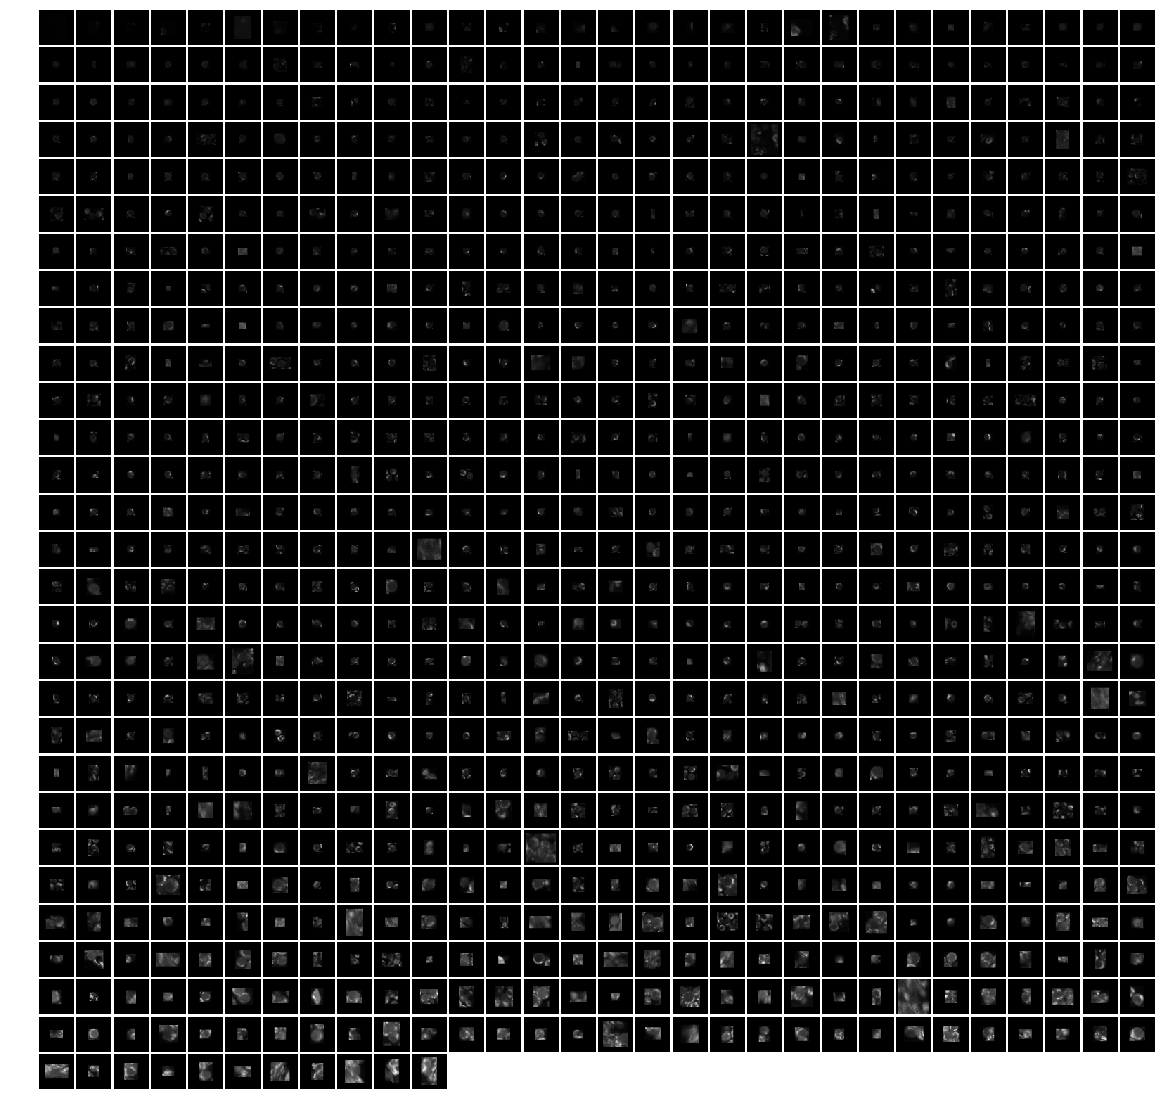

In [13]:
# Plot the padded images with entropy order
padded_images_sorted = [i.replace('original', 'processed/padded') for i in
                        original_images_sorted]
montage = montage_images(padded_images_sorted, 30, image_size=50, margin=3)

plt.figure(figsize=(20, round(montage.shape[1] / montage.shape[0] * 20)))
plt.imshow(montage, cmap='gray')
plt.axis('off')
plt.show()

### 3.2. Entropy Thresholding

As shown above, entropy does a good job on sorting images based on how informative they are. Therefore, it helps us detect images with no cells. The next step is to find a entropy threshold $a$ and discard images with entropy less than $\alpha$.

We suggest the following three strategies to find $\alpha$. Also, you can have different $\alpha$ values for different classes.

1. Manually pick $\alpha$ based on the sorted image overview
2. Choose the $n$th percentile entropy 
3. Fit a normal distribution, then use the cumulative density function (CDF) to define $\alpha$

Method 1 and 2 are easy and good for small dataset (i.e. this sample dataset). Method 3 makes more sense if the sample size is large. Also, method 2 and method 3 can be easily extended when more images are added.

#### 3.2.1 Normal-based Thresholding

This section demonstrates how to use an approximated normal distribution to help define $\alpha$.

In [14]:
# Collect the entropies for activated and quiescent images seperately
activated_path = "./images/sample_images/original/*/activated/*.png"
quiescent_path = "./images/sample_images/original/*/quiescent/*.png"

total_a_entropy = [compute_entropy(n) for n in
                   set(glob(activated_path))- discard_images]
total_q_entropy = [compute_entropy(n) for n in
                   set(glob(quiescent_path)) - discard_images]

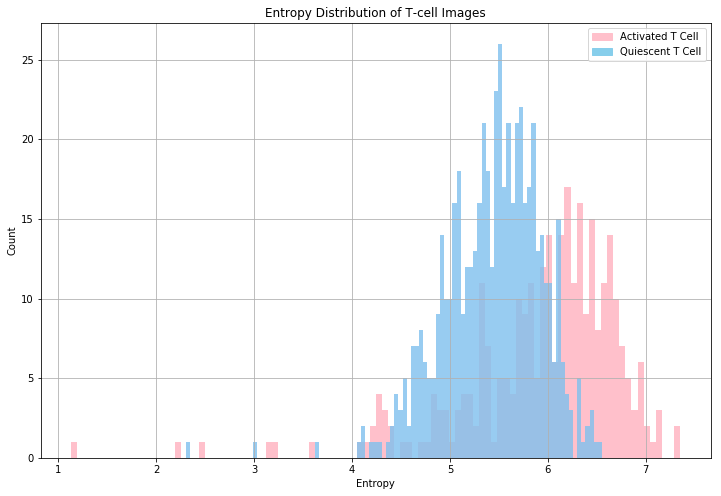

In [15]:
f, ax1 = plt.subplots(1, sharey=True, figsize=(12, 8))

n, bins, patches = ax1.hist(total_a_entropy, 100, facecolor='pink')
n, bins, patches = ax1.hist(total_q_entropy, 100, facecolor=(126/255,
                                                             192/255,
                                                             238/255,
                                                             0.8))

ax1.set_xlabel('Entropy')
ax1.set_ylabel('Count')
ax1.set_title("Entropy Distribution of T-cell Images")
ax1.grid(True)

pink_patch = mpatches.Patch(color='pink', label='Activated T Cell')
blue_patch = mpatches.Patch(color='skyblue', label='Quiescent T Cell')
plt.legend(handles=[pink_patch, blue_patch])

plt.show()

The entry distributions for two classes are different. Therefore, it might make more sense if we select $\alpha$ differently for activated T-cell image and quiescent T-cell image.

In [16]:
# The cdf quantile. Suppose it is 0.01, then we want to find alpha
# where P(e <= alpha) = 0.05, where e ~ N(mu, sigma)
cdf_q = 0.01

# Approximated gaussian for quiescent cells
q_mean = np.mean(total_q_entropy)
q_var = np.var(total_q_entropy, ddof=1)
q_cutoff = norm.ppf(q=cdf_q, loc=q_mean, scale=np.sqrt(q_var))
print("The cut-off of quiescent cells for lower " +
      "{:.0f}% is at point {}.".format(cdf_q * 100, q_cutoff))


# Approximated gaussian for activated cells
a_mean = np.mean(total_a_entropy)
a_var = np.var(total_a_entropy, ddof=1)
a_cutoff = norm.ppf(q=cdf_q, loc=a_mean, scale=np.sqrt(a_var))
print("The cut-off of activated cells for lower " +
      "{:.0f}% is at point {}.".format(cdf_q * 100, a_cutoff))

The cut-off of quiescent cells for lower 1% is at point 4.272699416794639.
The cut-off of activated cells for lower 1% is at point 4.027638947349481.


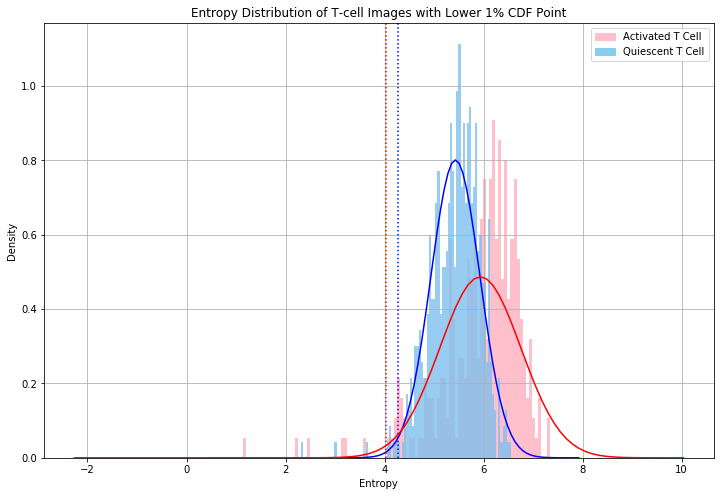

In [17]:
f, ax1 = plt.subplots(1, sharey=True, figsize=(12, 8))

n, bins, patches = ax1.hist(total_a_entropy, 100, facecolor='pink',
                            density=True)
n, bins, patches = ax1.hist(total_q_entropy, 100, facecolor=(126/255,
                                                             192/255,
                                                             238/255,
                                                             0.8),
                            density=True)

# Add normal plot
# The dist is slightly left skewed, so we plot more area on the left tail
x_q = np.linspace(q_mean - 10*np.sqrt(q_var), q_mean + 5*np.sqrt(q_var), 100)
ax1.plot(x_q, norm.pdf(x_q, q_mean, np.sqrt(q_var)), color="blue")
ax1.axvline(x=q_cutoff, color="blue", linestyle=':')

x_a = np.linspace(a_mean - 10*np.sqrt(a_var), a_mean + 5*np.sqrt(a_var), 100)
ax1.plot(x_a, norm.pdf(x_a, a_mean, np.sqrt(a_var)), color="red")
ax1.axvline(x=a_cutoff, color="red", linestyle=':')

ax1.set_xlabel('Entropy')
ax1.set_ylabel('Density')
ax1.set_title("Entropy Distribution of T-cell Images with Lower " +
              "{:.0f}% CDF Point".format(cdf_q*100))
ax1.grid(True)

pink_patch = mpatches.Patch(color='pink', label='Activated T Cell')
blue_patch = mpatches.Patch(color='skyblue', label='Quiescent T Cell')
plt.legend(handles=[pink_patch, blue_patch])

plt.show()

Next, we can try to apply these two thresholds to filter dim images.

In [18]:
def display_single_row_montage(img_list, title, row_nitem=None, fig_width=20):
    """
    Organize images in `img_list` in one row and display them in Jupyter
    notebook.
    
    Args:
        img_list([string]): list of image names
        title(string): the title for the displaying figure
        row_nitem(int): if set, this function will display multiple rows where
            each row has <= `row_nitem` images
        row_len(int): the figure width
    """
    overview = montage_images(img_list, row_nitem if row_nitem else len(img_list),
                              image_size=50, margin=3)

    plt.figure(figsize=(fig_width, round(overview.shape[1] / overview.shape[0]
                                         * fig_width)))
    plt.imshow(overview, cmap='gray')
    plt.title(title, fontdict = {'fontsize' : 20})
    plt.axis('off')
    plt.show()

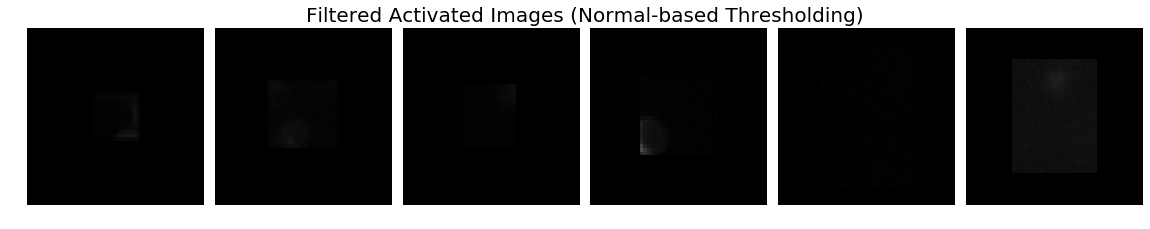

In [19]:
activated_path = "./images/sample_images/original/*/activated/*.png"
filtered_a_images = [i.replace('original', 'processed/padded') for i in 
                     set(glob(activated_path)) - 
                     discard_images if compute_entropy(i) < a_cutoff]

display_single_row_montage(filtered_a_images, "Filtered Activated Images "+
                           "(Normal-based Thresholding)")

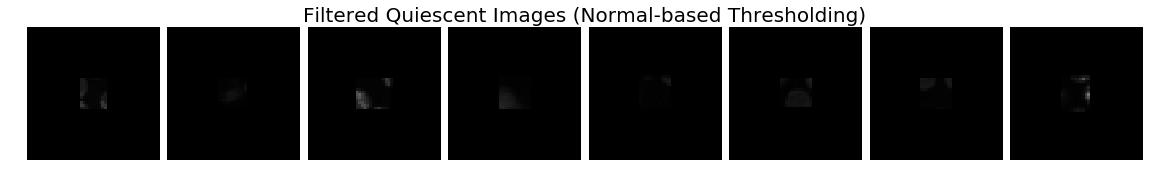

In [20]:
quiescent_path = "./images/sample_images/original/*/quiescent/*.png"
filtered_q_images = [i.replace('original', 'processed/padded') for i in
                     set(glob(quiescent_path)) - 
                     discard_images if compute_entropy(i) < q_cutoff]

display_single_row_montage(filtered_q_images, "Filtered Quiescent Images " +
                           "(Normal-based Thresholding)")

### 3.3. Two-step Thresholding

In [Section 3.2.1](#3.2.1-Normal-based-Thresholding), using one entropy threshold helps detect images without cell. However, entropy is not perfect. For example, an image having a large range of low intensity pixels has higher entropy than an image only having few high intensity pixels. In practice, the latter image is more likely to include a cell. One could decrease the threshold $\alpha$ to avoid false positives, but the filter would become too conservative.

To address this issue in larger dataset, we propose a two-step thresholding filter which uses both image entropy and total intensity.

1. Use a progressive entropy filter (entropy $\leq \alpha_1$) first
2. Use a conservative entropy filter combined with a progressive total intensity filter (entropy $\leq \alpha_2$ and total intensity $\leq \beta$) to refine the model

We can use the same methods as discussed in [Section 3.2](#3.2.-Entropy-Thresholding) to pick $\alpha_1, \alpha_2, \beta$. We can also have different $\left(\alpha_1, \alpha_2, \beta\right)$ tuples for different image classes.

<img src="./plots/two_step_thresholding.png" width=300>

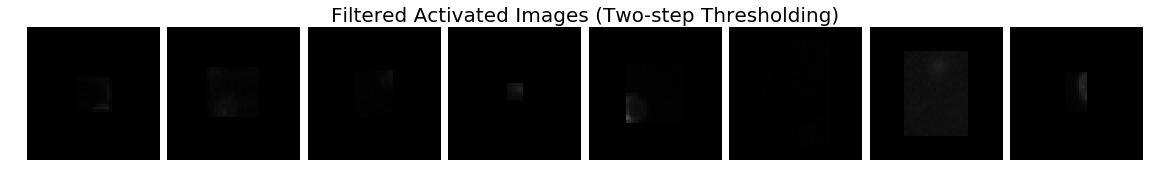

In [21]:
# In this example, we use the same pair of (a1, a2, b)
# for both activated and quiescent images
alpha_1 = 4
alpha_2 = 4.7
beta = 3500

filtered_a_images = []
activated_path = "./images/sample_images/original/*/activated/*.png"
for n in set(glob(activated_path)) - discard_images:
    cur_entropy = compute_entropy(n)
    cur_intensity = np.sum(cv2.imread(n, 0))
    
    # Two-step thresholding
    if cur_entropy < alpha_1 or (cur_entropy < alpha_2 and cur_intensity < beta):
        filtered_a_images.append(n.replace('original', 'processed/padded'))

display_single_row_montage(filtered_a_images, "Filtered Activated Images " +
                           "(Two-step Thresholding)")

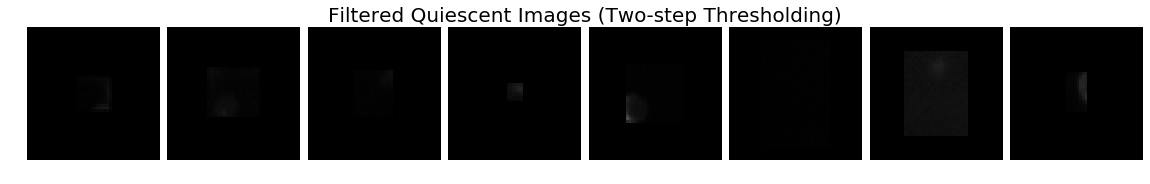

In [22]:
filtered_q_images = []
quiescent_path = "./images/sample_images/original/*/activated/*.png"
for n in set(glob(quiescent_path)) - discard_images:
    cur_entropy = compute_entropy(n)
    cur_intensity = np.sum(cv2.imread(n, 0))
    
    # Two-step thresholding
    if cur_entropy < alpha_1 or (cur_entropy < alpha_2 and cur_intensity < beta):
        filtered_q_images.append(n.replace('original', 'processed/padded'))

display_single_row_montage(filtered_q_images, "Filtered Quiescent Images " +
                           "(Two-step Thresholding)")

This method filters out more "bad cropping" images while maintaining a low false positive rate.

### 3.4. Multiple-cell Detection

In some datasets, there are many images with multiple cells in them. One can use the standard binary thresholding and connected component detection to filter them out. Since this is not a big issue for this T-cell dataset, we did not apply this filter.

Below is the example code to detect those images.

In [23]:
def has_multiple_cell(img_name):
    """
    Use binary threshold and connected components to detect number of cells.
    
    Args:
        img_name: path to the image file
    
    Returns:
        bool: true if this image include mutliple cells
    """
    # Constant 20 is the binary threshold value
    img = cv2.imread(img_name, 0)
    _, thresh = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)
    result = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)

    # The constant 10 is just another thresholding parameter
    if result[0] >= 10:
        return True
    else:
        return False

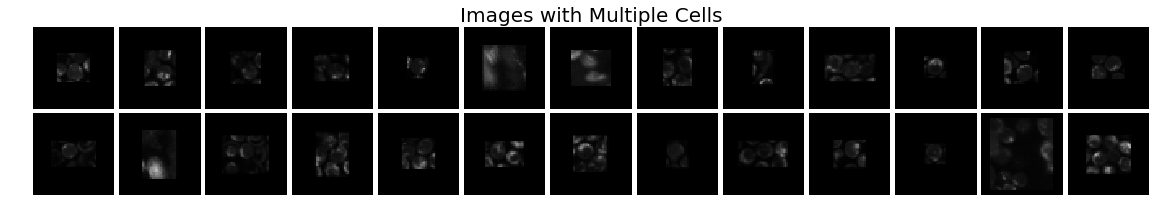

In [24]:
multi_cell_images = []
image_path = "./images/sample_images/original/*/*/*.png"
for n in set(glob(image_path)) - discard_images:
    if has_multiple_cell(n):
        multi_cell_images.append(n.replace('original', 'processed/padded'))

display_single_row_montage(multi_cell_images, "Images with Multiple Cells",
                           row_nitem=13)

## 4. Image Augmentation

After filtering some "bad cropped" images, we can add augmented images to increase the training dataset and make the classifier more robust.

In [25]:
# Remove filtered images using two-step thresholding
# Instead of "literally" delete filtered images, we copy legit images
# into a new directory as you don't need to worry about the execution
# order of notebook cells
discard_images = discard_images.union(set(filtered_a_images)).union(set(filtered_q_images))

image_path = "./images/sample_images/processed/padded/*/*/*.png"
for n in (set(glob(image_path)) - discard_images):
    
    # Create intermediate directories
    target_location = n.replace('padded', 'augmented')
    intermediate_dirs, _ = os.path.split(target_location)
    if not exists(intermediate_dirs):
        os.makedirs(intermediate_dirs)
        
    copyfile(n, target_location)

### 4.1. Rotation

For each selected padded image, we generate 3 rotated (90°, 180°, 270°) copies.

In [26]:
def rotate(image_name):
    """
    Rotate the image 90 degree three times, then save three new images to
    the same directory of `image_name`.
    
    Args:
        image_name: path to the image
    """
    image = Image.open(image_name)
    dirs, base_name = os.path.split(image_name)
    name = base_name.split('.')

    for degree in [90, 180, 270]:
        new_name = name[0] + "_r{}.png".format(degree)
        image.rotate(degree).save(join(dirs, new_name))

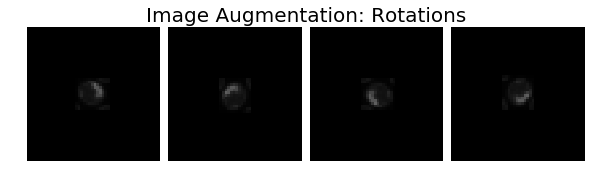

In [27]:
for n in glob("./images/sample_images/processed/augmented/*/*/*.png"):
    # Skip augmented images (to avoid notebook cell execution order conflict)
    if 'r' in basename(n) or 'f' in basename(n):
        continue
    
    rotate(n)

demo_base = ("images/sample_images/processed/augmented/donor_1/"
             "quiescent/CD3_1_noact_10_1_7")
demo_images = [demo_base + s + '.png' for s in ['', '_r90', '_r180', '_r270']]
display_single_row_montage(demo_images, "Image Augmentation: Rotations",
                           fig_width=10)

### 4.2. Mirroring

For each selected padded image, we generate 2 flipped (vertically and horizontally) copies.

In [28]:
def flip(image_name):
    """
    Flip the image vertically and horizontally (mirroring), then
    save three new images to the same directory of `image_name`.
    
    Arugs:
        image_name: path to the image
    """
    image = cv2.imread(image_name)
    dirs, base_name = os.path.split(image_name)
    name = base_name.split('.')

    x_flip = cv2.flip(image, 0)
    x_name = name[0] + "_xf.png"
    y_flip = cv2.flip(image, 1)
    y_name = name[0] + "_yf.png"

    cv2.imwrite(join(dirs, x_name), x_flip)
    cv2.imwrite(join(dirs, y_name), y_flip)

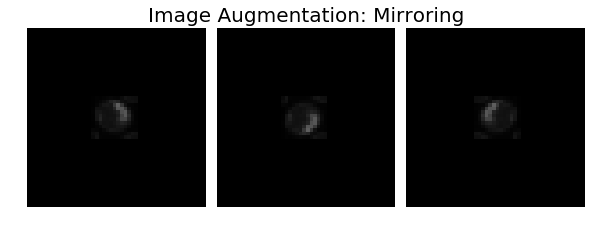

In [29]:
for n in glob("./images/sample_images/processed/augmented/*/*/*.png"):
    # Skip augmented images (to avoid notebook cell execution order conflict)
    if 'r' in basename(n) or 'f' in basename(n):
        continue
    
    flip(n)

demo_base = ("images/sample_images/processed/augmented/donor_1/"
             "quiescent/CD3_1_noact_10_1_7")
demo_images = [demo_base + s + '.png' for s in ['', '_xf', '_yf']]
display_single_row_montage(demo_images, "Image Augmentation: Mirroring",
                           fig_width=10)

## 5. Summary

In this notebook, we designed an image processing pipeline to prepare single cell images for classification. Within each step, many decisions were made based on this sample T-cell dataset. You might want to adjust the methods to fit your own dataset.

1. Examine all images
2. Resize images
3. Discard uninformative images
4. Image augmentation


|Step|Activated Count|Quiescent Count|
|:---:|:---:|:---:|
|Raw Images|302|550|
|Resizing|301|550|
|Filtering|293|538|
|Augmentation|1758|3228|